# Reporte de calidad
En este notebooks se presentará el reporte de calidad de los datos proporcionado para el proyecto, un resumen del EDA, las transformaciones realizadas y los datos obtenidos de otras fuentes.

In [1]:
# Importamos las librerías a utilizar
import pandas as pd                         # Manejo de datos
import numpy as np                          # Manejo de datos
import matplotlib.pyplot as plt             # Graficos
import seaborn as sns                       # Graficos
import datetime                             # Formato de fechas
from wordcloud import WordCloud             # Word cloud
from nltk.corpus import stopwords           # Eliminar stopwords
from flydenity import Parser                # Obtener información de los vuelos
from geopy.geocoders import Nominatim       # Obtener latitud y longitud
from ast import literal_eval as make_tuple  # Tuplas en str a tuple

# Graficar con latitud y longitud
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Temas para graficar
plt.style.use('ggplot')
sns.set_style("darkgrid")

## Datos iniciales
El conjunto de datos de este proyecto está conformado por 5008 filas con información sobre accidentes de aviones. Inicialmente posee las siguientes columnas:

```
    Unnamed: 0 : columna de indices
    fecha : fecha del accidente
    HORA declarada : hora del accidente
    Ruta : lugar del accidente
    OperadOR : entidad 
    flight_no : número de vuelo
    route : ruta de vuelo
    ac_type : tipo de avión
    registration : código de registro del vuelo
    cn_ln : número de construcción o número serial
    all_aboard : número de personas abordo del vuelo
    PASAJEROS A BORDO : número de pasajeros abordo del vuelo
    crew_aboard : número de miembros de la tripulación del avión
    cantidad de fallecidos : número de fallecidos del vuelo
    passenger_fatalities : número de fallecidos que eran pasajeros
    crew_fatalities : número de fallecidos que eran tripulación
    ground : número de fallecidos en tierra
    summary : resumen del accidente

```
A continuación se encuentran los valores faltantes por cada columna:

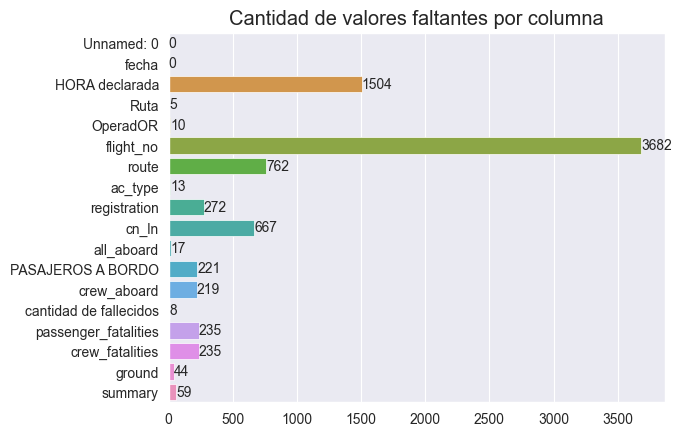

In [2]:
df = pd.read_csv('dataset/AccidentesAviones.csv')
# remplazamos ? por None para revisar los valores faltantes
df.replace({'?':None}, inplace=True)
# Ploteamos el numero de faltantes por columna
ax = sns.barplot(x = df.isnull().sum().values, y = df.columns)
ax.bar_label(ax.containers[0])
plt.title('Cantidad de valores faltantes por columna');

Y la cantidad de valores únicos:

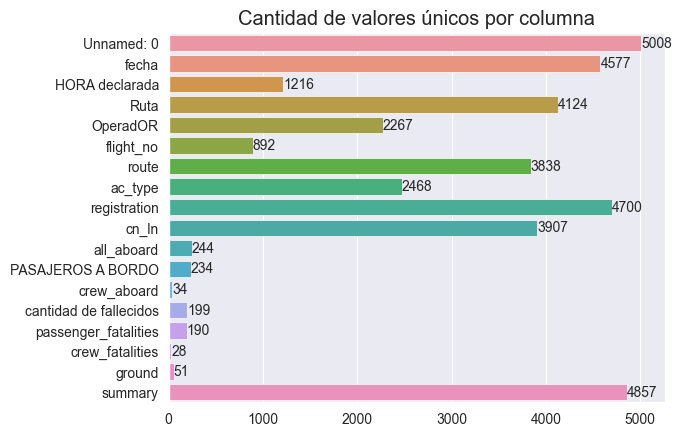

In [3]:
ax = sns.barplot(x = df.nunique().values, y = df.columns)
ax.bar_label(ax.containers[0])
plt.title('Cantidad de valores únicos por columna');

## EDA
### Variables iniciales
Se renombraron algunas variables:
```
    Unnamed: 0 --> id
    fecha --> date
    HORA declarada --> time
    Ruta --> location 
    OperadOR --> operator 
    ac_type --> plane_type 
    PASAJEROS A BORDO --> passengers 
    all_aboard --> aboard 
    crew_aboard --> crew 
    cantidad de fallecidos --> fatalities 
```
Para los strings y las variables numéricas se hicieron las transformaciones usuales (eliminar espacios en blanco, cambiar el tipo de dato, etc).

De las variables numéricas podemos ver las relaciones entre variables y sus distribuciones

In [4]:
df = pd.read_csv('dataset/datos_reporte.csv')
columnas_iniciales = ['id', 'aboard', 'passengers', 'crew', 'fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground', 'location', 'operator', 'route', 'plane_type']

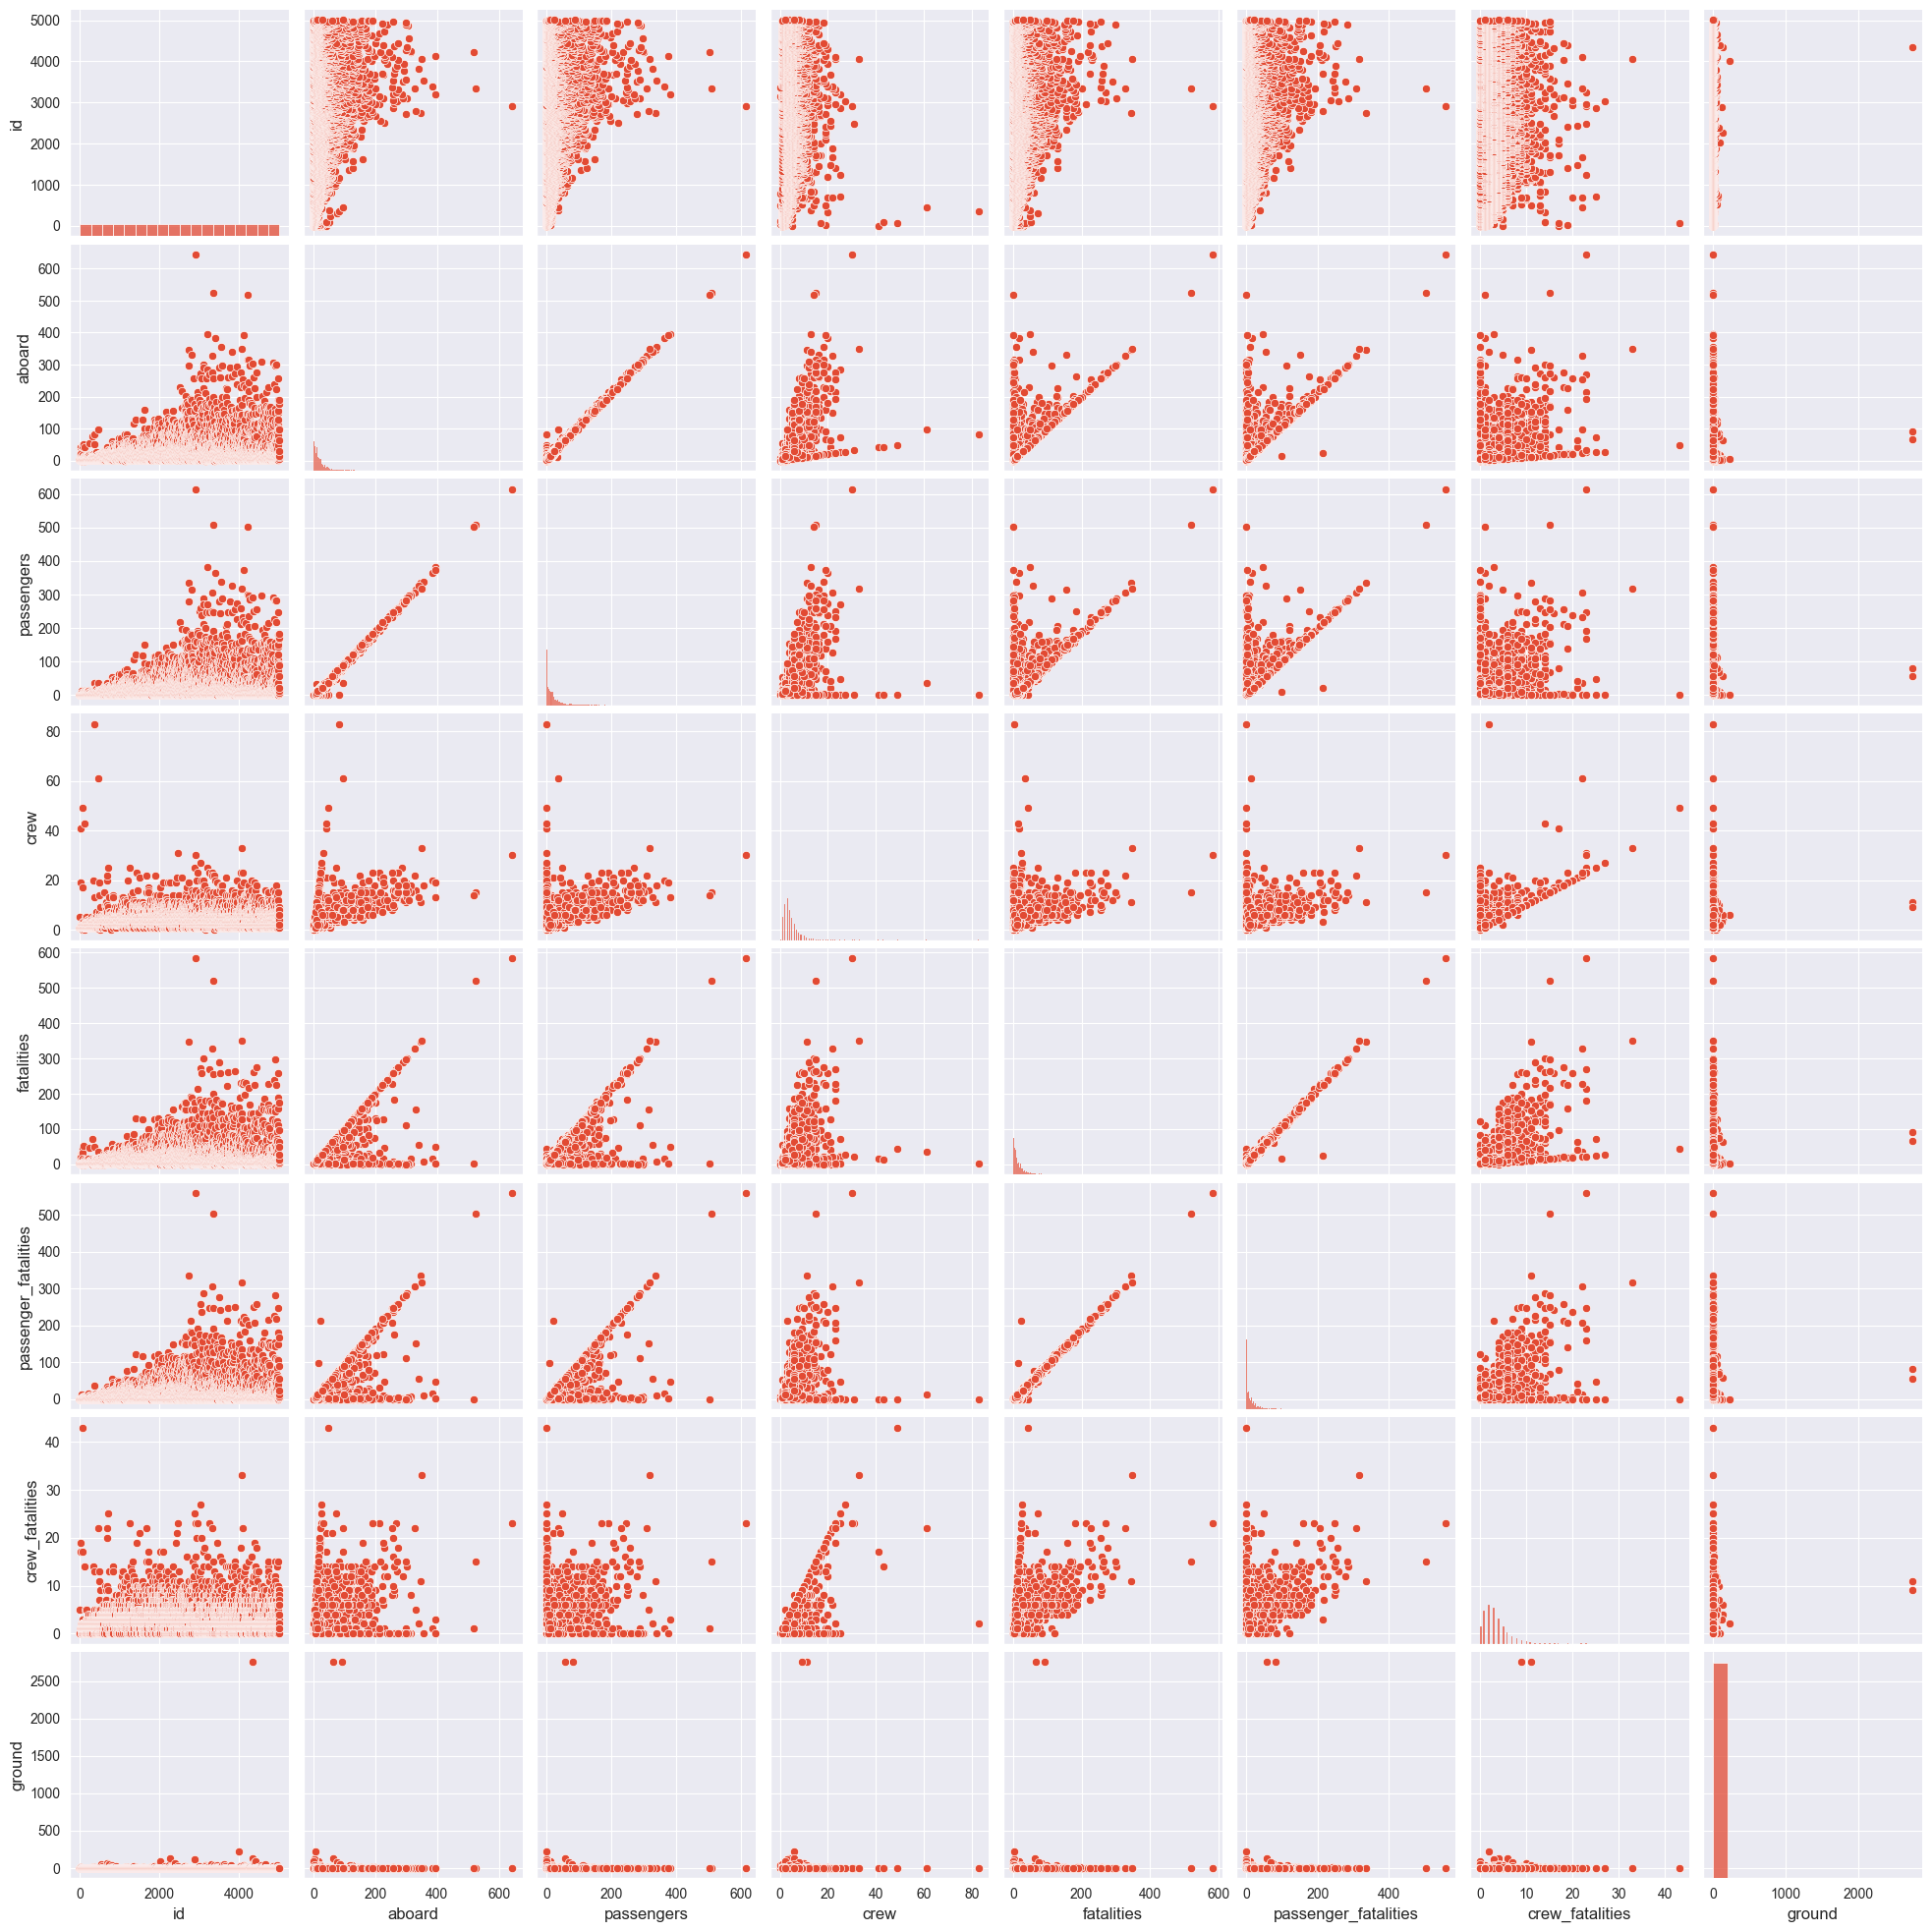

In [5]:
sns.pairplot(data=df[columnas_iniciales]);

Y su correlación

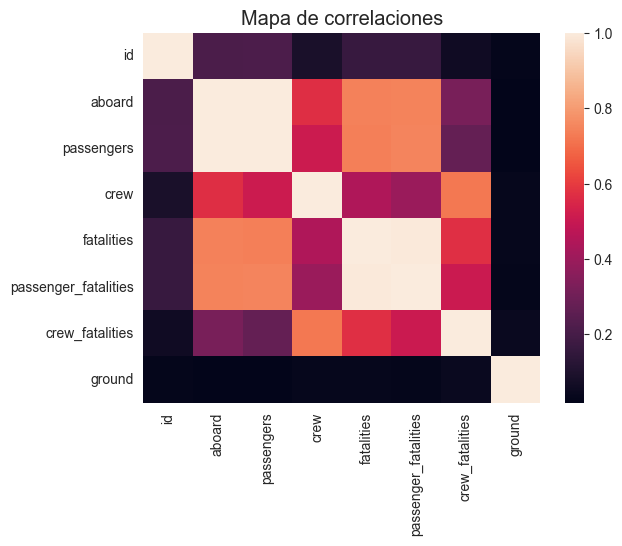

In [6]:
sns.heatmap(df[columnas_iniciales].corr(numeric_only=True))
plt.title('Mapa de correlaciones');

Y de las cualitativas podemos ver barplots

In [7]:
def ten_values(df, column, axis=None):
    '''Plot de los 10 valores principales agrupados por cuenta'''

    plane = df.pivot_table(index = [column], aggfunc ='size').sort_values(ascending=False)
    
    # Opcion para ejes
    if axis:
        sns.barplot(ax=axis, x=plane.values[:10], y=plane.index[:10])
    else:
        sns.barplot(x=plane.values[:10], y=plane.index[:10])
        plt.title('10 {} con más accidentes'.format(column))
        plt.show()
        plt.close()

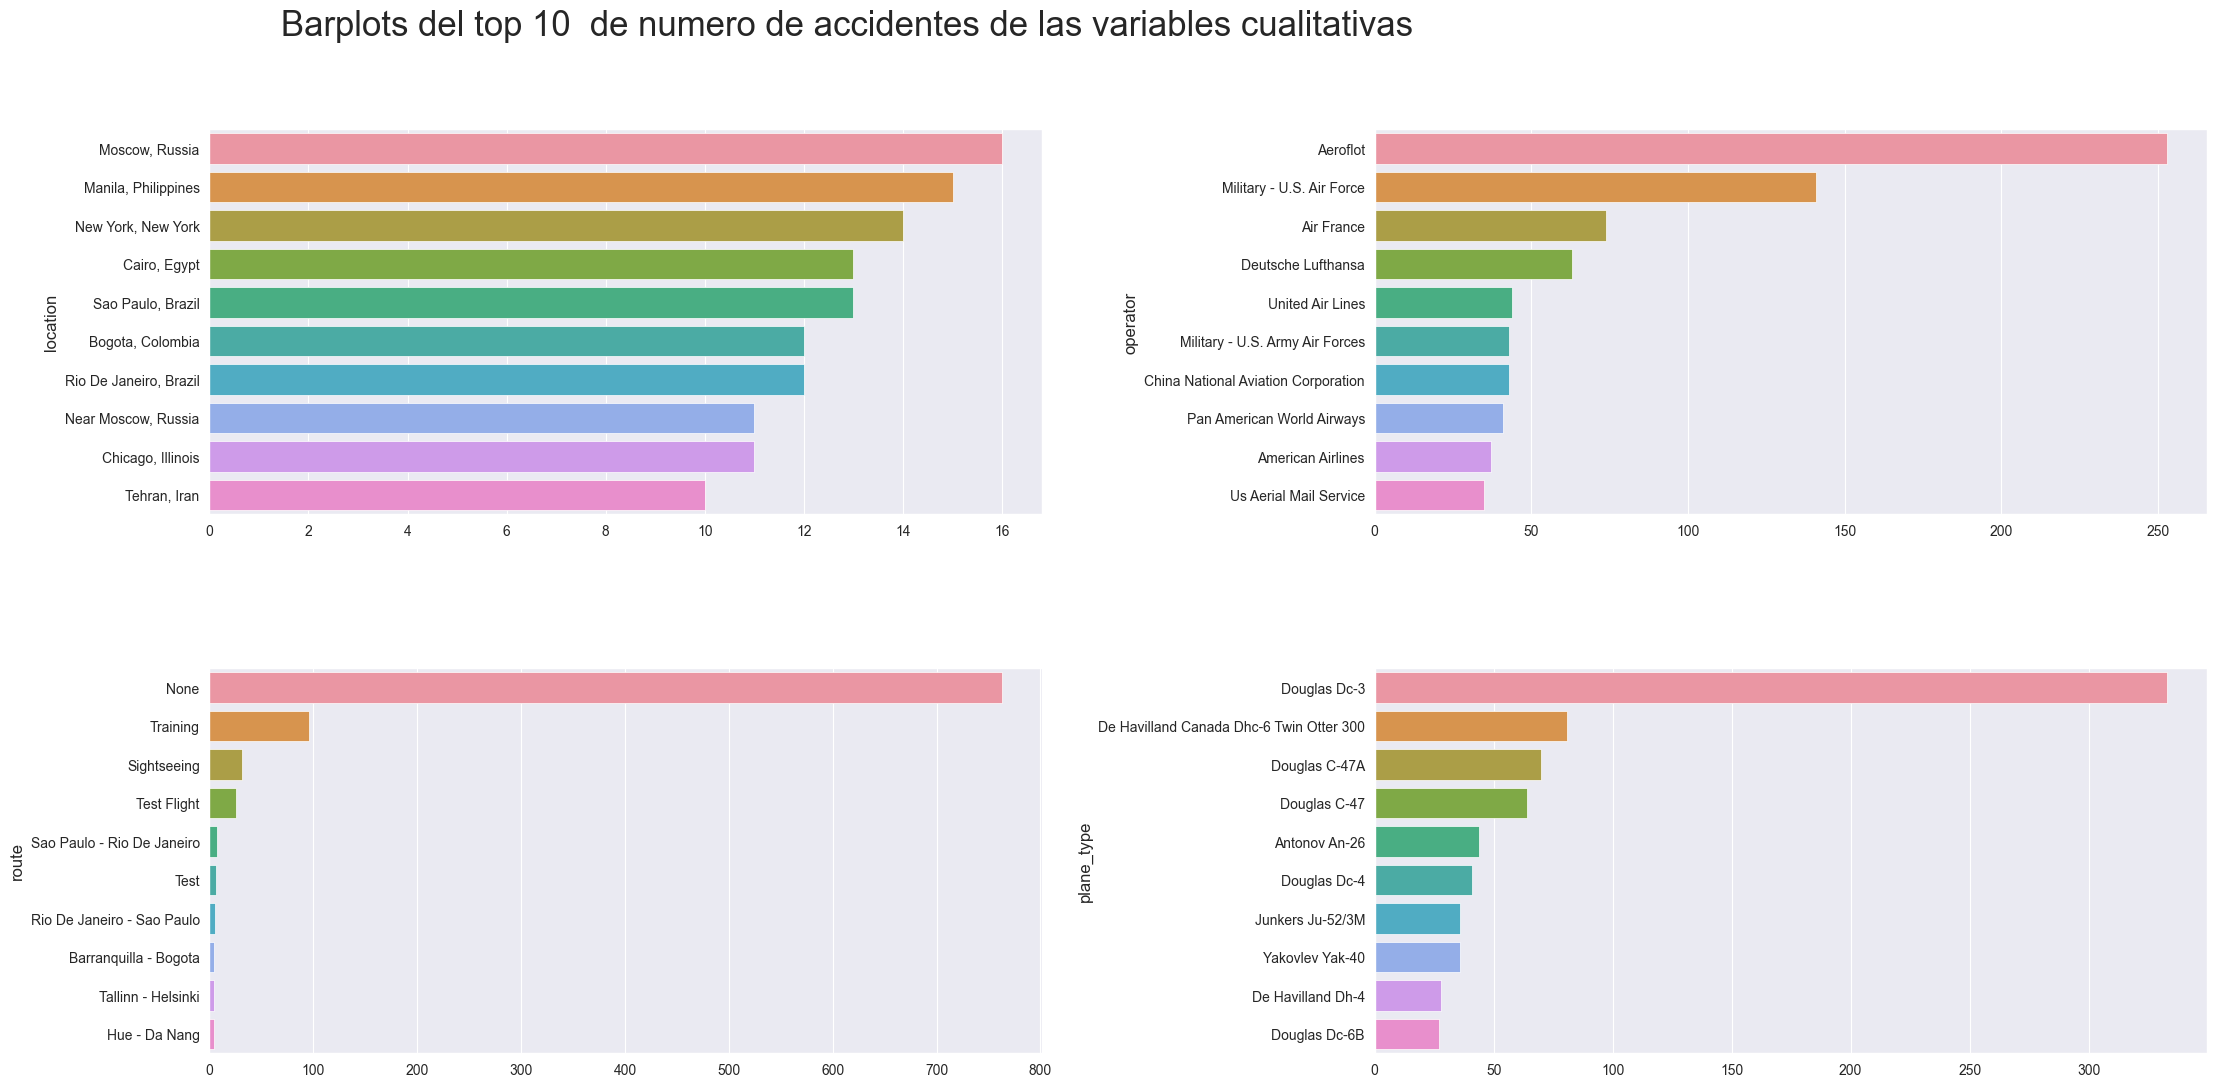

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(17,12))
columns = ['location', 'operator', 'route', 'plane_type']
fig.suptitle('Barplots del top 10  de numero de accidentes de las variables cualitativas', fontsize=25)
nvar=0

for ii in range(2):
    for jj in range(2):
        ten_values(df, columns[nvar], axis=axes[ii, jj])
        nvar+=1

plt.subplots_adjust(right=1.3,
                    wspace=0.4,
                    hspace=0.4)

A nivel temporal, podemos ver la cantidad de accidentes por año:

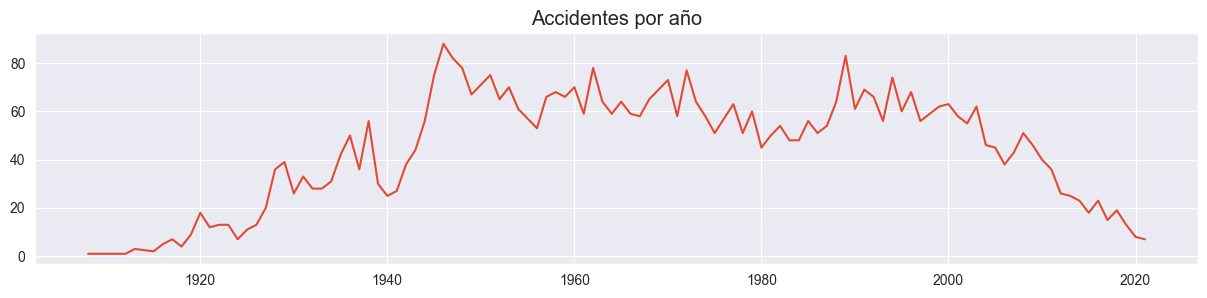

In [9]:
# convertimos a datetime
df['date'] = pd.to_datetime(df.date)
# hacemos una serie contando las filas por fecha
yearly = df.date.dt.year.value_counts()
# ploteamos
plt.figure(figsize=(15,3))
sns.lineplot(x=yearly.index, y=yearly.values)
plt.title('Accidentes por año');

Con la variable `summary` podemos visualizar las palabras más comúnes con un wordcloud

In [10]:
# eliminamos conectores
stop = stopwords.words('english')
# calculamos la frecuencia
S = df.summary.str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
S['count'] = S.str.split(expand=True).stack().value_counts()
S = S['count'].reset_index()
S.rename(columns = {0:'count'}, inplace=True)

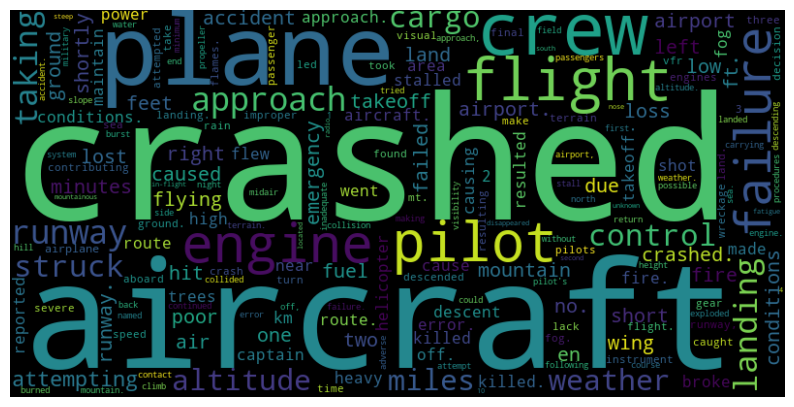

In [11]:
# hacemos el plot del word cloud 
data = S.set_index('index').to_dict()['count']
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Variables calculadas
A partir de las variables inciales se caculó:
```
    survivors : número de sobrevivientes del vuelo, calculando aboard - fatalities
    crash_place : el lugar del accidente, más general que location
    day_week : día de la semana del accidente
    month_year : mes del año del accidente
    military : si en el accidente estuvo involucrado un ente militar, a partir de la información en summary
```
Además, se crearon columnas boleanas relacionadas a la causa del accidente, a partir de la información de la columna `summary`.

Visualicemos algunas de estas variables:

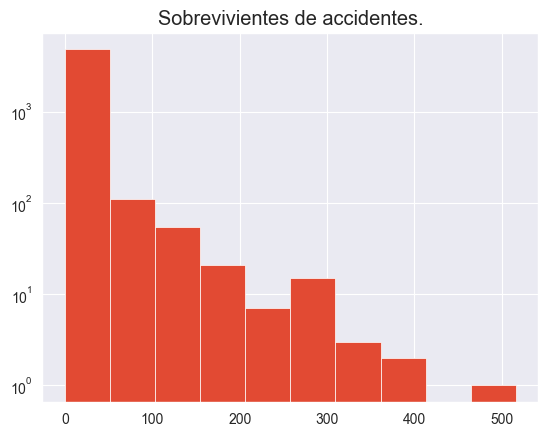

In [12]:
df['survivors'] = df.aboard - df.fatalities
df.survivors.hist(log=True)
plt.title('Sobrevivientes de accidentes.');

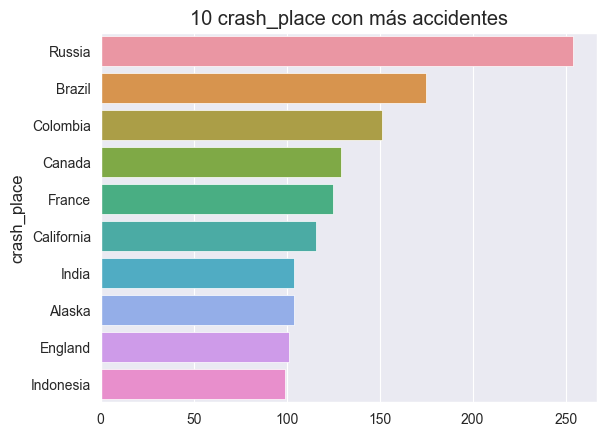

In [13]:
ten_values(df, 'crash_place')

Vemos que el lugar donde más aviones tienen accidentes es en Rusia.

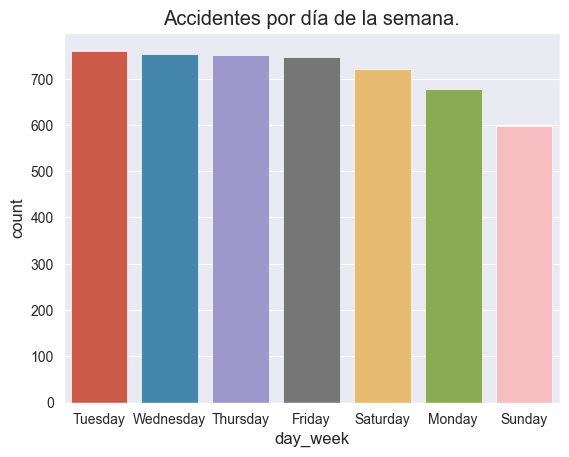

In [14]:
df['day_week'] = pd.DatetimeIndex(df['date']).day_name()
sns.countplot(x=df.day_week,order = df.day_week.value_counts().index)
plt.title('Accidentes por día de la semana.');


El domingo es el dia de la semana con menos accidentes.

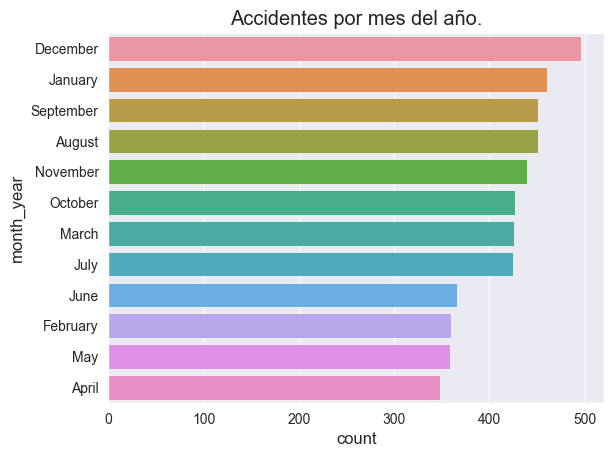

In [15]:
df['month_year'] = pd.DatetimeIndex(df['date']).month_name()
sns.countplot(y=df.month_year, order= df.month_year.value_counts().index)
plt.title('Accidentes por mes del año.');

Diciembre es el mes del año con más accidentes, pero probablemente también hayan más vuelos.

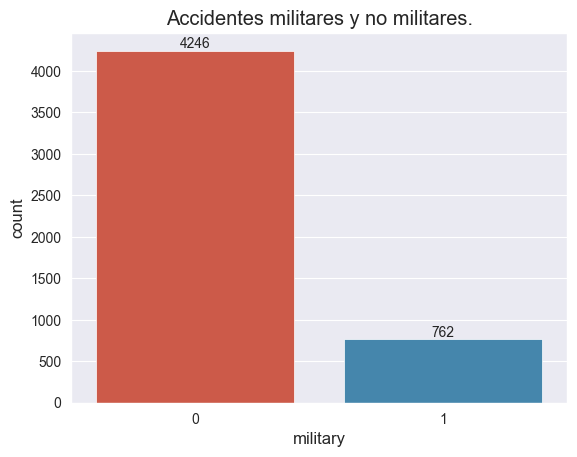

In [16]:
# 1 significa militar
df.military = df.military.astype(int)
ax = sns.countplot(data=df, x='military')
ax.bar_label(ax.containers[0])
plt.title('Accidentes militares y no militares.');

Como aproximación, vemos que hay menos accidentes militares.

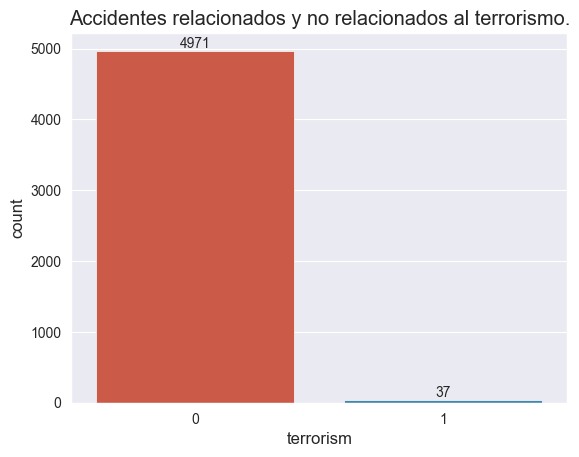

In [17]:
# 1 significa que hay relacion al terrorismo
ax = sns.countplot(data=df, x='terrorism')
ax.bar_label(ax.containers[0])
plt.title('Accidentes relacionados y no relacionados al terrorismo.');

Hay pocos accidentes relacionados al terrorismo.

### Outliers
Los outliers se pueden visualizar más facilmente con boxplots:

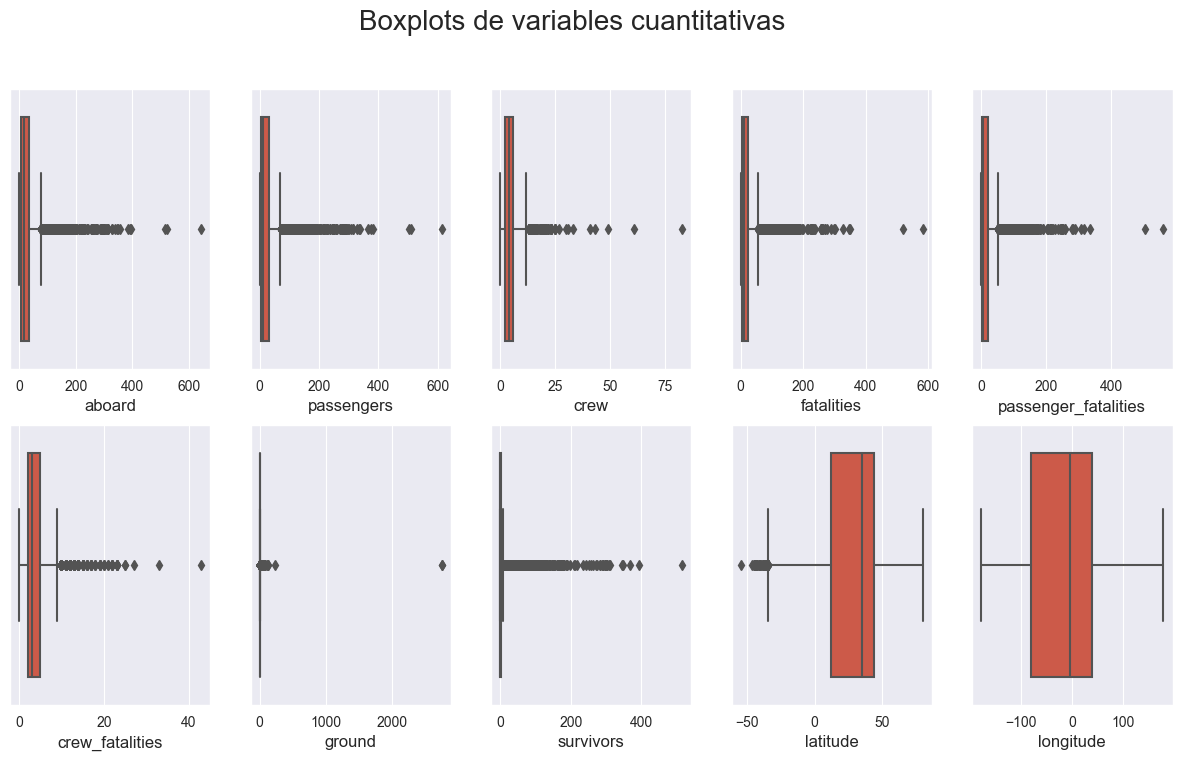

In [18]:
columns = ['aboard', 'passengers', 'crew', 'fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground', 'survivors', 'latitude', 'longitude']
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Boxplots de variables cuantitativas', fontsize=20)
nvar=0

for ii in range(2):
    for jj in range(5):
        sns.boxplot(ax=axes[ii, jj], data=df, x=columns[nvar])
        nvar+=1

Vemos, por ejemplo, un outlier en ground:

In [19]:
df.loc[df.ground == df.ground.max()][columnas_iniciales]

,id,aboard,passengers,crew,fatalities,passenger_fatalities,crew_fatalities,ground,location,operator,route,plane_type
4346,4346,92.0,81.0,11.0,92.0,81.0,11.0,2750.0,"New York City, New York",American Airlines,Boston - Los Angeles,Boeing 767-223Er
4347,4347,65.0,56.0,9.0,65.0,56.0,9.0,2750.0,"New York City, New York",United Air Lines,Boston - Los Angeles,Boeing B-767-222


Correspondiente a los atentados de 9/11, los accidentes de avión con mayor cantidad de fallecidos.

## Datos externos

Para complementar el dataset, se obtuvieron datos externos a partir de las siguientes fuentes:
- [geopy](https://github.com/geopy/geopy), para obtener las coordenadas de los lugares de los accidentes.
- [flydenity](https://github.com/Collen-Roller/flydenity), para obtener información sobre el lugar de partida del vuelo a través del código de registro.
- [Datos de worldbank](https://data.worldbank.org/indicator/IS.AIR.DPRT?end=2016&start=1970&view=chart) sobre la cantidad de pasajeros de aviones por año.

Visualicemos estos datos:

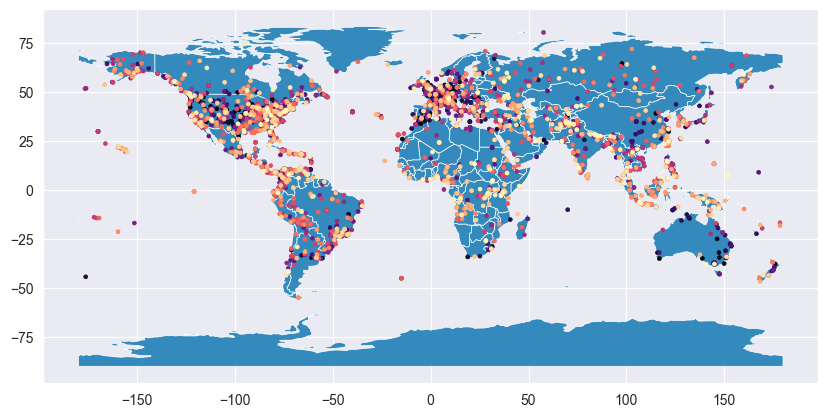

In [20]:
# Graficamos los coordenas obtenidos
dfpos = df.loc[(df.latitude.notnull())&(df.longitude.notnull())].copy()

geometry = [Point(xy) for xy in zip(dfpos['longitude'], dfpos['latitude'])]
gdf = GeoDataFrame(dfpos, geometry=geometry)    

# Ploteamos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', cmap='magma', markersize=8);

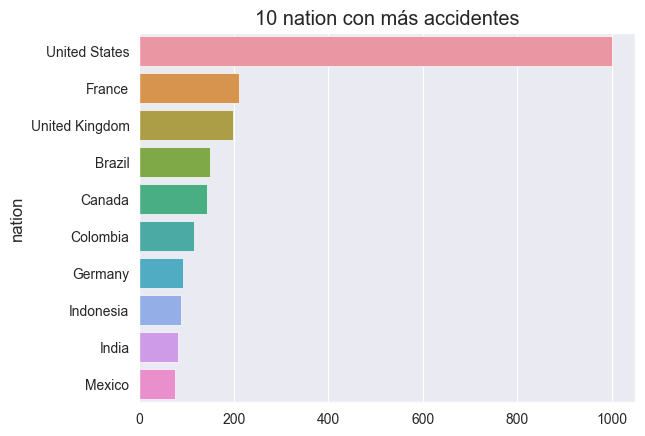

In [21]:
df_aviones = pd.read_csv('dataset/departure_planes.csv')
# graficamos los paises de salida con mas accidentes
ten_values(df_aviones, 'nation')

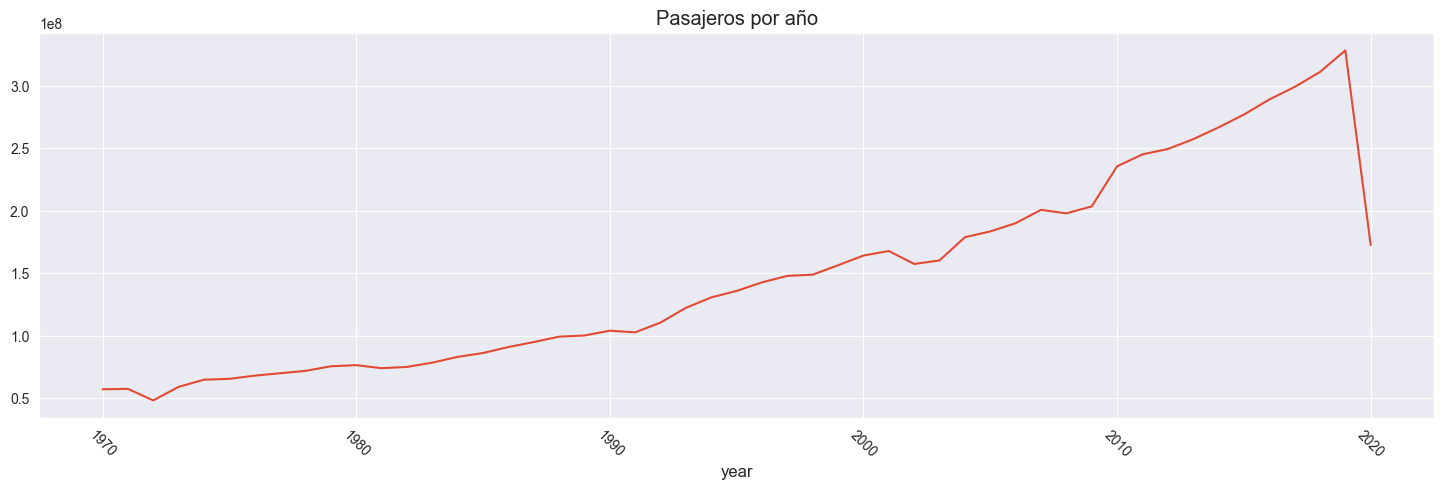

In [22]:
# Cantidad de pasajeros por año
df_passengers = pd.read_csv('dataset/passengers_per_year.csv')
df_passengers.set_index('year', inplace=True)

plt.figure(figsize=(18,5))
sns.lineplot(x=df_passengers.index, y=df_passengers.values.reshape(-1))
plt.xticks(rotation=-45)
plt.title('Pasajeros por año');

## Datos finales
Los datos finales que se obtienen luego de correr el notebook `EDA.ipynb` quedaron de la siguiente manera>

El dataset de accidentes de aviones (plane_accidents.csv):
```
    date : fecha del accidente
    time : hora del accidente
    operator :  
    route : ruta de vuelo
    plane_type : tipo de avión
    registration : código de registro del vuelo
    aboard : número de personas abordo del vuelo
    passengers : número de pasajeros abordo del vuelo
    crew : número de miembros de la tripulación del avión
    fatalities : número de fallecidos del vuelo
    passenger_fatalities : número de fallecidos que eran pasajeros
    crew_fatalities : número de fallecidos que eran tripulación
    ground : número de fallecidos en tierra
    crash_place : lugar del accidente
    survivors : cantidad de sobrevivientes
    day_week : dia de semana del accidente
    month_year : mes del año del accidente
    military : columna booleana. 1 representa que el vuelo esta relacionado a la milicia
    human_error : columna booleana. 1 representa que el accidente está relacionado al error humano
    landing : columna booleana. 1 representa que el accidente sucedió al aterrizar
    mechanical_issues : columna booleana. 1 representa que hubo problemas mecánicos en el vuelo
    takeoff : columna booleana. 1 representa que el accidente sucedió al despegar
    terrorism : columna booleana. 1 representa que el accidente está relacionado a terrorismo
    water_crash : columna booleana. 1 representa que el accidente sucedió en el mar
    weather : columna booleana. 1 representa que el accidente está relacionado al clima
```


Datos sobre el pais de salida de los aviones (departure_planes.csv):
```
    plane_id : codigo de registro del avión
    nation : país de salida del vuelo
    description : tipo de vuelo / avión / linea
    iso2 : código de país de dos letras
    iso3 : código de país de tres letras

```

Datos sobre la cantidad de pasajeros de aviones por año (passengers_per_year.csv):
```
    year : año a considerar
    sum : cantidad de pasajeros de avión a nivel mundial
```

El dataset principal posee la siguiente cantidad de valores faltantes:

date                    0.00
time                    0.00
operator                0.00
route                   0.00
plane_type              0.00
registration            0.00
aboard                  0.34
passengers              4.41
crew                    4.37
fatalities              0.16
passenger_fatalities    4.69
crew_fatalities         4.69
ground                  0.88
crash_place             0.00
survivors               0.34
day_week                0.00
month_year              0.00
military                0.00
human_error             0.00
landing                 0.00
mechanical_issues       0.00
takeoff                 0.00
terrorism               0.00
water_crash             0.00
weather                 0.00
dtype: float64

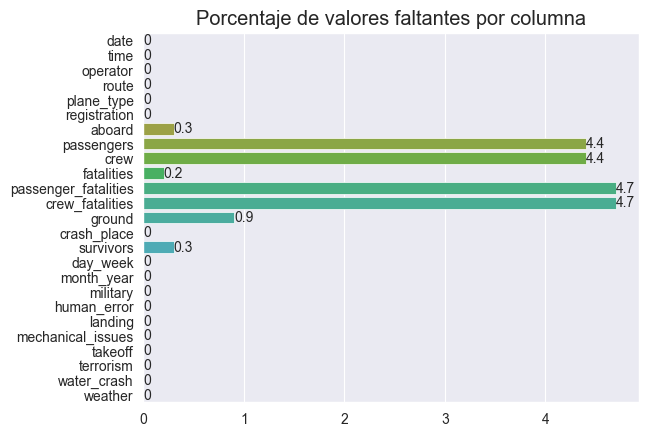

In [33]:
df = pd.read_csv('dataset/plane_accidents.csv')
# Ploteamos el numero de faltantes por columna
percentage = round(df.isnull().sum()/df.shape[0]*100,1)
ax = sns.barplot(x = percentage.values, y = df.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de valores faltantes por columna');